In [12]:
%pip install tf-keras-vis


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from keras.datasets import cifar10

# Carregar CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalizar
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Usar apenas 1 canal (ex.: canal R)
x_train_r = x_train[:,:,:,0:1]
x_test_r = x_test[:,:,:,0:1]

print("Formato do x_test_r:", x_test_r.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Formato do x_test_r: (10000, 32, 32, 1)


00_exploracao:

Formato do treino: (50000, 32, 32, 3)
Formato do teste: (10000, 32, 32, 3)
Formato após remover canais (só R): (50000, 32, 32, 1)


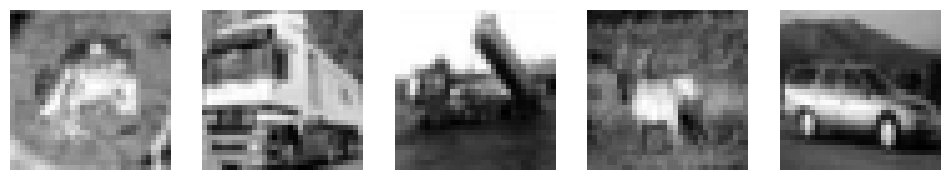

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10

# 1. Carregar CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Formato do treino:", x_train.shape)  # (50000, 32, 32, 3)
print("Formato do teste:", x_test.shape)    # (10000, 32, 32, 3)

# 2. Normalizar os valores [0,255] -> [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 3. Remover canais -> exemplo: manter apenas canal R (índice 0)
x_train_r = x_train[:,:,:,0:1]  # mantém só o canal R
x_test_r = x_test[:,:,:,0:1]

# Você também pode trocar o 0 por 1 (G) ou 2 (B)

print("Formato após remover canais (só R):", x_train_r.shape)

# 4. Visualizar algumas imagens
fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    axes[i].imshow(x_train_r[i].squeeze(), cmap="gray")
    axes[i].axis("off")
plt.show()


01_mlp_baseline:

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1813 - loss: 2.1937 - val_accuracy: 0.2353 - val_loss: 2.0952
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2190 - loss: 2.1111 - val_accuracy: 0.2635 - val_loss: 2.0348
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2363 - loss: 2.0803 - val_accuracy: 0.2736 - val_loss: 2.0238
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2419 - loss: 2.0611 - val_accuracy: 0.2716 - val_loss: 2.0243
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2501 - loss: 2.0446 - val_accuracy: 0.2879 - val_loss: 1.9942
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2549 - loss: 2.0283 - val_accuracy: 0.2802 - val_loss: 1.9971
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2601 - loss: 2.0202 - val_accuracy: 0.2770 - val_loss: 2.0034
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2623 - loss: 2.0064 - val_accuracy: 0.

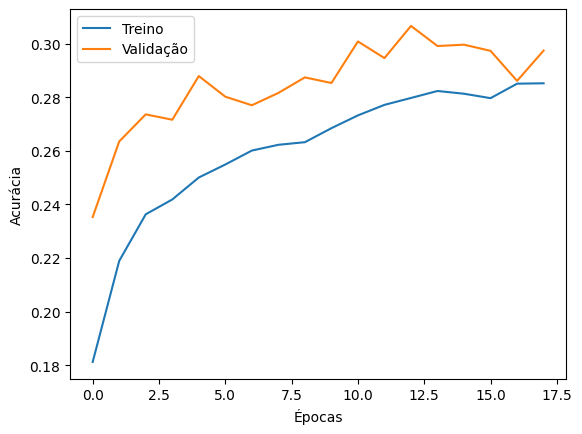

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


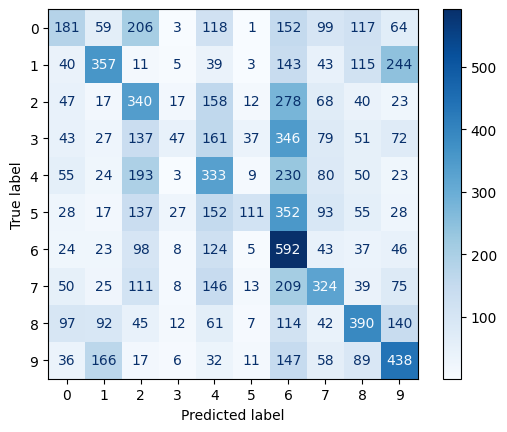

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # type: ignore
import numpy as np

# Dados (usando o canal R já preparado)
x_train_mlp = x_train_r.reshape((x_train_r.shape[0], -1))  # Flatten
x_test_mlp = x_test_r.reshape((x_test_r.shape[0], -1))

num_classes = 10

# Modelo MLP
mlp = keras.Sequential([
    layers.Input(shape=(32*32,)),       # Flatten implícito
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

mlp.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("mlp_best.keras", save_best_only=True)
]

# Treinamento
history = mlp.fit(
    x_train_mlp, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=callbacks
)

# Avaliação no teste
test_loss, test_acc = mlp.evaluate(x_test_mlp, y_test)
print(f"Acurácia no teste: {test_acc:.4f}")

# Curvas
plt.plot(history.history["accuracy"], label="Treino")
plt.plot(history.history["val_accuracy"], label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

# Matriz de confusão
y_pred = np.argmax(mlp.predict(x_test_mlp), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.show()


02_cnn_model:

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore

num_classes = 10

# CNN baseline
cnn = keras.Sequential([
    layers.Input(shape=(32, 32, 1)),
    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.Flatten(),
    layers.Dropout(0.5),  # regularização
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks (early stopping e melhor modelo salvo)
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("cnn_best.keras", save_best_only=True)
]

# Treinamento
history = cnn.fit(
    x_train_r, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=callbacks
)

# Avaliação no teste
test_loss, test_acc = cnn.evaluate(x_test_r, y_test)
print(f"Acurácia no teste: {test_acc:.4f}")

# Salvar modelo final
cnn.save("cnn_best.keras")



Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.3893 - loss: 1.7092 - val_accuracy: 0.5047 - val_loss: 1.4623
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5516 - loss: 1.2866 - val_accuracy: 0.6060 - val_loss: 1.1537
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6123 - loss: 1.1213 - val_accuracy: 0.6347 - val_loss: 1.0532
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6453 - loss: 1.0162 - val_accuracy: 0.6479 - val_loss: 0.9927
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6769 - loss: 0.9333 - val_accuracy: 0.6665 - val_loss: 0.9552
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6949 - loss: 0.8778 - val_accuracy: 0.7011 - val_loss: 0.8672
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7164 - loss: 0.8154 - val_accuracy: 0.6917 - val_loss: 0.8969
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7359 - loss: 0.7650 - 

03_gradcam_e_erros:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
Total de erros: 6887
Acurácia: 0.3113


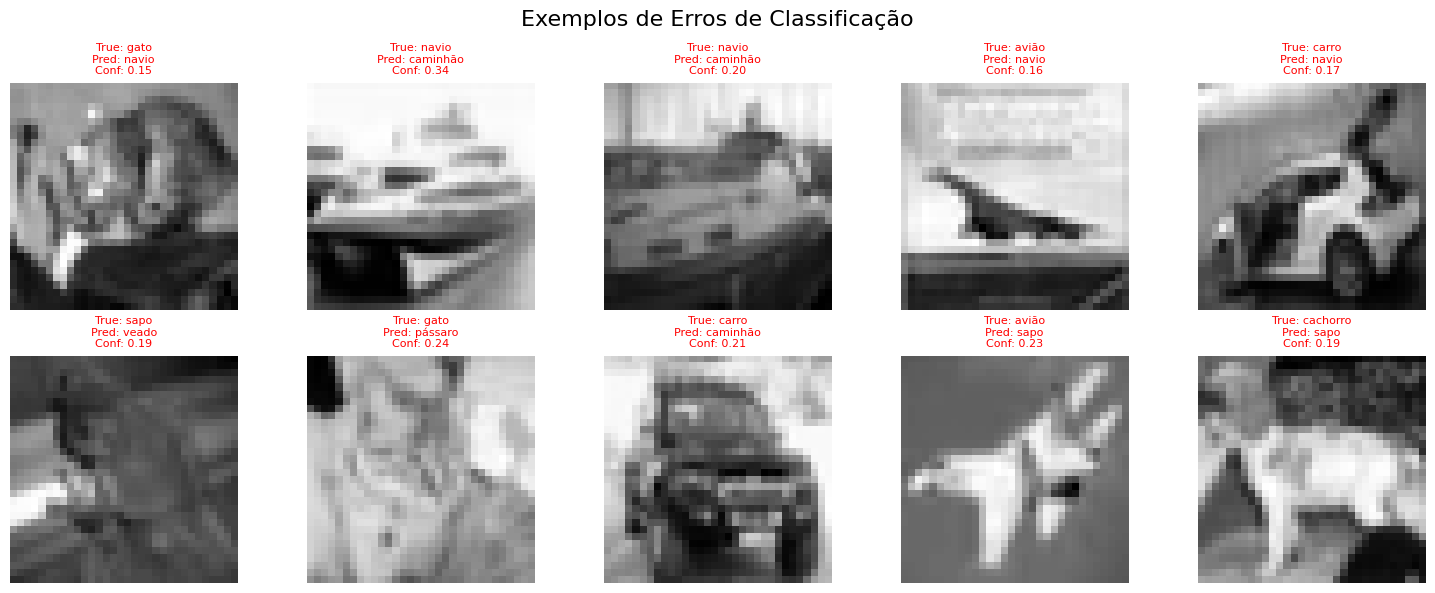

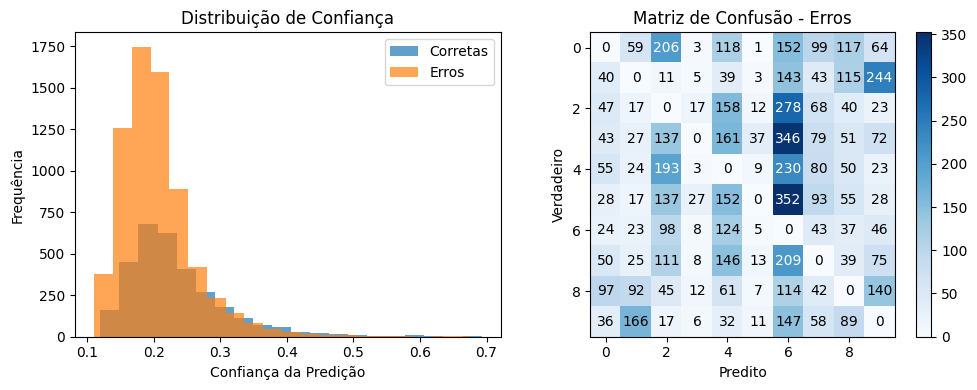

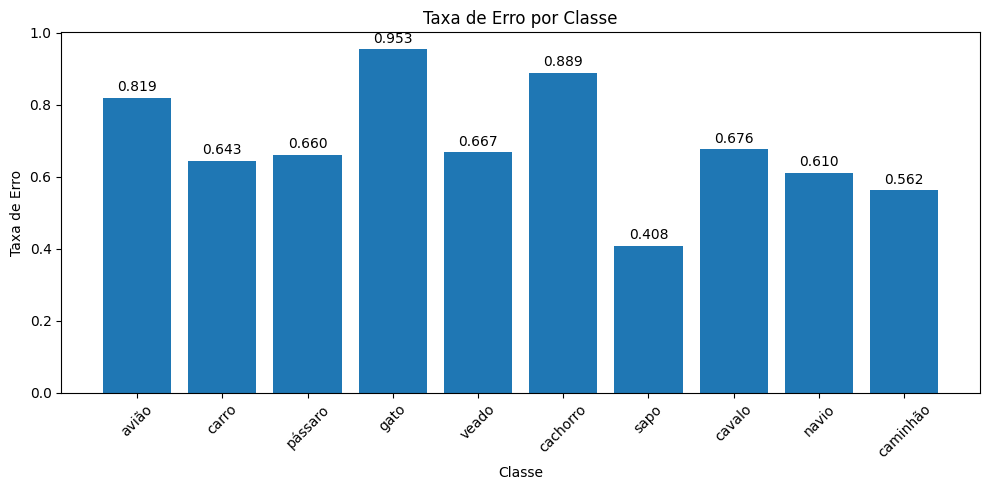


Análise Detalhada por Classe:
avião: 0.819 (819/1000)
  Confundido com: carro:59, pássaro:206, gato:3, veado:118, cachorro:1, sapo:152, cavalo:99, navio:117, caminhão:64
carro: 0.643 (643/1000)
  Confundido com: avião:40, pássaro:11, gato:5, veado:39, cachorro:3, sapo:143, cavalo:43, navio:115, caminhão:244
pássaro: 0.660 (660/1000)
  Confundido com: avião:47, carro:17, gato:17, veado:158, cachorro:12, sapo:278, cavalo:68, navio:40, caminhão:23
gato: 0.953 (953/1000)
  Confundido com: avião:43, carro:27, pássaro:137, veado:161, cachorro:37, sapo:346, cavalo:79, navio:51, caminhão:72
veado: 0.667 (667/1000)
  Confundido com: avião:55, carro:24, pássaro:193, gato:3, cachorro:9, sapo:230, cavalo:80, navio:50, caminhão:23
cachorro: 0.889 (889/1000)
  Confundido com: avião:28, carro:17, pássaro:137, gato:27, veado:152, sapo:352, cavalo:93, navio:55, caminhão:28
sapo: 0.408 (408/1000)
  Confundido com: avião:24, carro:23, pássaro:98, gato:8, veado:124, cachorro:5, cavalo:43, navio:37, camin

In [8]:
# 03_gradcam_e_erros
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tf_keras_vis.gradcam import Gradcam # type: ignore
from tf_keras_vis.utils import normalize # type: ignore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus # type: ignore
import cv2

# Carregar o modelo treinado
model = keras.models.load_model('mlp_best.keras')

# Preparar os dados (usando canal R)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_test_r = x_test[:,:,:,0:1].astype("float32") / 255.0
x_test_mlp = x_test_r.reshape((x_test_r.shape[0], -1))

# Fazer previsões
y_pred = model.predict(x_test_mlp)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.squeeze()

# Encontrar erros
errors = y_pred_classes != y_true
error_indices = np.where(errors)[0]

print(f"Total de erros: {len(error_indices)}")
print(f"Acurácia: {1 - len(error_indices)/len(y_test):.4f}")

# Analisar alguns erros
class_names = ['avião', 'carro', 'pássaro', 'gato', 'veado',
               'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

# Plotar alguns erros
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Exemplos de Erros de Classificação', fontsize=16)

for i, idx in enumerate(error_indices[:10]):
    ax = axes[i//5, i%5]

    # Imagem original (canal R)
    img = x_test_r[idx].squeeze()
    ax.imshow(img, cmap='gray')

    true_class = class_names[y_true[idx]]
    pred_class = class_names[y_pred_classes[idx]]
    confidence = np.max(y_pred[idx])

    ax.set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}',
                 fontsize=8, color='red')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Análise de confiança nos erros
confidences_errors = np.max(y_pred[errors], axis=1)
confidences_correct = np.max(y_pred[~errors], axis=1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(confidences_correct, alpha=0.7, label='Corretas', bins=20)
plt.hist(confidences_errors, alpha=0.7, label='Erros', bins=20)
plt.xlabel('Confiança da Predição')
plt.ylabel('Frequência')
plt.legend()
plt.title('Distribuição de Confiança')

plt.subplot(1, 2, 2)
# Matriz de confusão dos erros
from sklearn.metrics import confusion_matrix # type: ignore
cm = confusion_matrix(y_true[errors], y_pred_classes[errors])

plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Erros')

# Adicionar valores na matriz
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j]}',
                ha='center', va='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.show()

# Análise por classe
error_rates = []
for i in range(10):
    class_indices = y_true == i
    class_errors = np.sum(y_pred_classes[class_indices] != i)
    total_class = np.sum(class_indices)
    error_rate = class_errors / total_class if total_class > 0 else 0
    error_rates.append(error_rate)

plt.figure(figsize=(10, 5))
bars = plt.bar(range(10), error_rates)
plt.xlabel('Classe')
plt.ylabel('Taxa de Erro')
plt.title('Taxa de Erro por Classe')
plt.xticks(range(10), class_names, rotation=45)

# Adicionar valores nas barras
for bar, rate in zip(bars, error_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nAnálise Detalhada por Classe:")
for i, class_name in enumerate(class_names):
    class_indices = y_true == i
    if np.sum(class_indices) > 0:
        class_errors = np.sum(y_pred_classes[class_indices] != i)
        total_class = np.sum(class_indices)
        error_rate = class_errors / total_class

        # Quais classes são confundidas
        confusion_with = []
        for j in range(10):
            if i != j:
                confusions = np.sum((y_true == i) & (y_pred_classes == j))
                if confusions > 0:
                    confusion_with.append(f"{class_names[j]}:{confusions}")

        print(f"{class_name}: {error_rate:.3f} ({class_errors}/{total_class})")
        if confusion_with:
            print(f"  Confundido com: {', '.join(confusion_with)}")


src/app.py

In [9]:
%pip install streamlit pyngrok


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing import image # type: ignore
import cv2

# Carregar modelo
cnn = keras.models.load_model("cnn_best.keras")

# Classes do CIFAR-10
classes = ["avião", "automóvel", "pássaro", "gato", "cervo",
           "cachorro", "sapo", "cavalo", "navio", "caminhão"]

st.title("Classificação CIFAR-10 com CNN")
uploaded_file = st.file_uploader("Envie uma imagem", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Abrir imagem
    img = image.load_img(uploaded_file, target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predição
    predictions = cnn.predict(img_array)
    class_idx = np.argmax(predictions)
    class_name = classes[class_idx]

    st.image(uploaded_file, caption=f"Classe prevista: {class_name}", use_column_width=True)

    # Probabilidades
    fig, ax = plt.subplots()
    ax.bar(classes, predictions[0])
    ax.set_xticklabels(classes, rotation=45, ha="right")
    st.pyplot(fig)


2025-09-27 12:21:19.940 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 12:21:20.267 
  command:

    streamlit run C:\Users\flori\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-27 12:21:20.268 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 12:21:20.268 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 12:21:20.268 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 12:21:20.269 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 12:21:20.269 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 12:21:20.269 Thre

In [13]:
!ngrok config add-authtoken 33Ez6uwEMvrZ4V6SWB5fjiuv6GT_6YfJTdLqweVG4xBWU3p4A

                                                                                                    
Installing ngrok ... 
                                                                                                    
Authtoken saved to configuration file: C:\Users\flori\AppData\Local/ngrok/ngrok.yml


In [14]:
from pyngrok import ngrok

# abre túnel para o localhost:8501
public_url = ngrok.connect("http://localhost:8501")
print("Acesse o app em:", public_url)

# inicia o app streamlit em segundo plano
!npm install -g localtunnel
!streamlit run app.py --server.port 8501 & npx localtunnel --port 8501

Acesse o app em: NgrokTunnel: "https://carinal-imagerial-adina.ngrok-free.dev" -> "http://localhost:8501"

added 22 packages, and audited 23 packages in 1s

3 packages are looking for funding
  run `npm fund` for details

1 high severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


npm notice 
npm notice New major version of npm available! 8.15.0 -> 11.6.1
npm notice Changelog: <https://github.com/npm/cli/releases/tag/v11.6.1>
npm notice Run `npm install -g npm@11.6.1` to update!
npm notice 


your url is: https://long-onions-hunt.loca.lt


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
npm WARN exec The following package was not found and will be installed: localtunnel@2.0.2
C:\Users\flori\AppData\Local\npm-cache\_npx\75ac80b86e83d4a2\node_modules\localtunnel\bin\lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:26395 (check your firewall settings)
    at Socket.<anonymous> (C:\Users\flori\AppData\Local\npm-cache\_npx\75ac80b86e83d4a2\node_modules\localtunnel\lib\TunnelCluster.js:52:11)
    at Socket.emit (node:events:518:28)
    at emitErrorNT (node:internal/streams/destroy:170:8)
    at emitErrorCloseNT (node:internal/streams/destroy:129:3)
    at process.processTicksAndRejections (node:internal/process/task_queues:90:21)

Node.js v22.11.0


In [1]:
# Célula: 00-setup
import os, random, pathlib, time
import numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
os.makedirs("figures", exist_ok=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TF version: 2.20.0
GPU available: []


In [2]:
# Célula: 01-data-load
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.ravel(); y_test = y_test.ravel()

# criar validação estratificada
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=5000, stratify=y_train, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)


(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


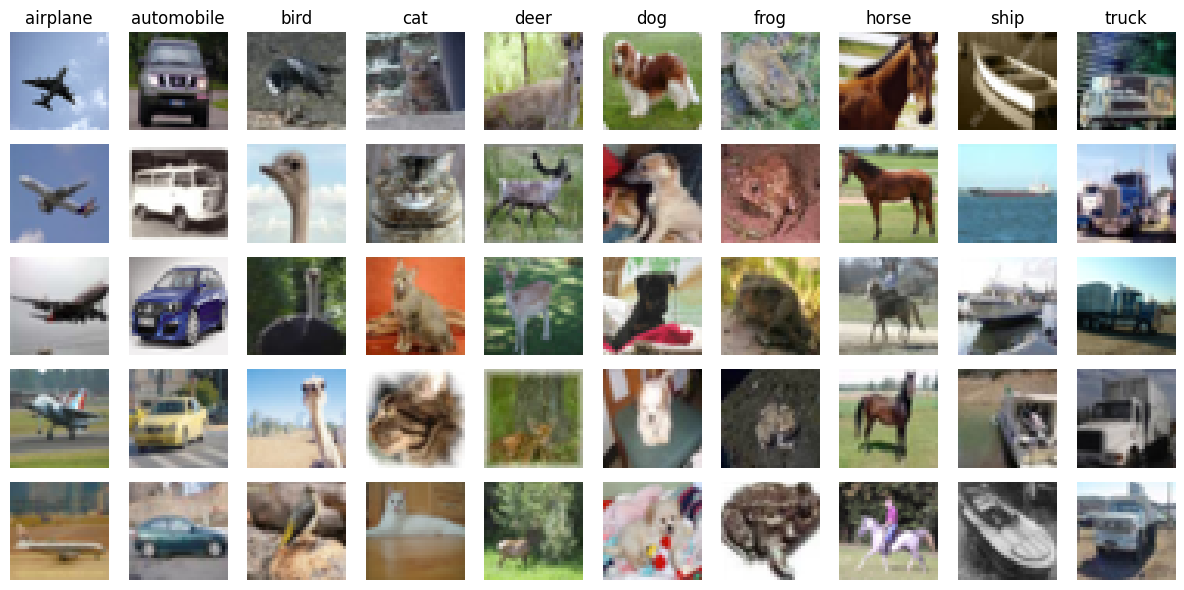

In [3]:
# Célula: 02-EDA (exemplo simples)
fig, axes = plt.subplots(5, 10, figsize=(12,6))
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for cls in range(10):
    idxs = np.where(y_train==cls)[0][:5]
    for i, ax in enumerate(axes[:,cls]):
        ax.imshow(X_train[idxs[i]])
        ax.axis('off')
        if i==0: ax.set_title(classes[cls])
plt.tight_layout()
plt.savefig("figures/dataset_examples.png", dpi=150)


In [4]:
# Célula: 03-preproc
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

rescale = Rescaling(1./255)
data_augment = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])


In [5]:
# Célula: 04-dataset-pipeline
def make_ds(X, y, batch=64, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(2000)
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (data_augment(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

batch_size = 128
ds_train = make_ds(X_train, y_train, batch=batch_size, training=True)
ds_val   = make_ds(X_val, y_val, batch=batch_size, training=False)
ds_test  = make_ds(X_test, y_test, batch=batch_size, training=False)


In [6]:
# Célula: 05-mlp
def build_mlp(input_shape=(32,32,3), num_classes=10, dropout=0.5, l2_reg=1e-4):
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name="MLP")
    return model

mlp = build_mlp()
mlp.summary()
print("params:", mlp.count_params())


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

params: 1707274


In [7]:
# Célula: 06-cnn
def build_cnn(input_shape=(32,32,3), num_classes=10, dropout=0.5, l2_reg=1e-4):
    inputs = keras.Input(shape=input_shape)
    x = rescale(inputs)
    x = layers.Conv2D(32,3,padding='same', activation='relu')(x)
    x = layers.Conv2D(32,3,padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64,3,padding='same', activation='relu')(x)
    x = layers.Conv2D(64,3,padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name="CNN")
    return model

cnn = build_cnn()
cnn.summary()
print("params:", cnn.count_params())


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,178 (293.66 KB)

 Trainable params: 75,178 (293.66 KB)

 Non-trainable params: 0 (0.00 B)

params: 75178


In [8]:
# Célula: 07-train-fn
def train_model(model, ds_train, ds_val, seed=42, epochs=50, model_name="model"):
    set_seed(seed)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    cb = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
        keras.callbacks.ModelCheckpoint(f"{model_name}_best.h5", save_best_only=True, monitor='val_loss')
    ]
    history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=cb)
    return history, model

# Exemplo:
# h_mlp, mlp_trained = train_model(mlp, ds_train, ds_val, seed=42, epochs=50, model_name="mlp")


In [9]:
# Célula: 08-experiments
import pandas as pd
seeds = [42, 123, 999]
results = []

for seed in seeds:
    # MLP
    mlp = build_mlp()
    h_mlp, mlp_trained = train_model(mlp, ds_train, ds_val, seed=seed, epochs=50, model_name=f"mlp_{seed}")
    preds = np.argmax(mlp_trained.predict(ds_test), axis=1)
    acc = (preds==y_test).mean()
    f1 = f1_score(y_test, preds, average='macro')
    results.append({"model":"MLP","seed":seed,"acc":acc,"f1":f1})
    # CNN
    cnn = build_cnn()
    h_cnn, cnn_trained = train_model(cnn, ds_train, ds_val, seed=seed, epochs=50, model_name=f"cnn_{seed}")
    preds = np.argmax(cnn_trained.predict(ds_test), axis=1)
    acc = (preds==y_test).mean()
    f1 = f1_score(y_test, preds, average='macro')
    results.append({"model":"CNN","seed":seed,"acc":acc,"f1":f1})

df_results = pd.DataFrame(results)
df_results.to_csv("figures/results_table.csv", index=False)
display(df_results.groupby("model").agg(["mean","std"]))


Epoch 1/50
350/352 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1588 - loss: 2.4082

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1800 - loss: 2.2665 - val_accuracy: 0.2662 - val_loss: 2.0694 - learning_rate: 0.0010
Epoch 2/50
350/352 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2065 - loss: 2.1532

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2102 - loss: 2.1363 - val_accuracy: 0.2938 - val_loss: 2.0121 - learning_rate: 0.0010
Epoch 3/50
350/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2197 - loss: 2.0966

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2240 - loss: 2.0868 - val_accuracy: 0.2968 - val_loss: 2.0013 - learning_rate: 0.0010
Epoch 4/50
350/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2375 - loss: 2.0576

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2391 - loss: 2.0483 - val_accuracy: 0.3002 - val_loss: 1.9995 - learning_rate: 0.0010
Epoch 5/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2391 - loss: 2.0394

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2388 - loss: 2.0383 - val_accuracy: 0.3102 - val_loss: 1.9850 - learning_rate: 0.0010
Epoch 6/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2462 - loss: 2.0172

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2466 - loss: 2.0144 - val_accuracy: 0.3134 - val_loss: 1.9651 - learning_rate: 0.0010
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2532 - loss: 2.0013 - val_accuracy: 0.2844 - val_loss: 1.9697 - learning_rate: 0.0010
Epoch 8/50
350/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2527 - loss: 2.0059

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2557 - loss: 1.9967 - val_accuracy: 0.2894 - val_loss: 1.9580 - learning_rate: 0.0010
Epoch 9/50
350/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2539 - loss: 1.9912

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2555 - loss: 1.9895 - val_accuracy: 0.3202 - val_loss: 1.9533 - learning_rate: 0.0010
Epoch 10/50
350/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2532 - loss: 1.9935

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2578 - loss: 1.9889 - val_accuracy: 0.3290 - val_loss: 1.9348 - learning_rate: 0.0010
Epoch 11/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2636 - loss: 1.9779 - val_accuracy: 0.3346 - val_loss: 1.9403 - learning_rate: 0.0010
Epoch 12/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2638 - loss: 1.9760 - val_accuracy: 0.2974 - val_loss: 1.9552 - learning_rate: 0.0010
Epoch 13/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2671 - loss: 1.9712

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2685 - loss: 1.9685 - val_accuracy: 0.3364 - val_loss: 1.9228 - learning_rate: 0.0010
Epoch 14/50
350/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2662 - loss: 1.9741

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2712 - loss: 1.9703 - val_accuracy: 0.3482 - val_loss: 1.9170 - learning_rate: 0.0010
Epoch 15/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2673 - loss: 1.9740 - val_accuracy: 0.3228 - val_loss: 1.9485 - learning_rate: 0.0010
Epoch 16/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2713 - loss: 1.9667 - val_accuracy: 0.3290 - val_loss: 1.9216 - learning_rate: 0.0010
Epoch 17/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2759 - loss: 1.9583

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2743 - loss: 1.9653 - val_accuracy: 0.3360 - val_loss: 1.9138 - learning_rate: 0.0010
Epoch 18/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2737 - loss: 1.9667 - val_accuracy: 0.3194 - val_loss: 1.9303 - learning_rate: 0.0010
Epoch 19/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2731 - loss: 1.9703 - val_accuracy: 0.3344 - val_loss: 1.9313 - learning_rate: 0.0010
Epoch 20/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2718 - loss: 1.9629 - val_accuracy: 0.3258 - val_loss: 1.9389 - learning_rate: 0.0010
Epoch 21/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2797 - loss: 1.9496

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2825 - loss: 1.9474 - val_accuracy: 0.3406 - val_loss: 1.9025 - learning_rate: 5.0000e-04
Epoch 22/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2864 - loss: 1.9414 - val_accuracy: 0.3312 - val_loss: 1.9231 - learning_rate: 5.0000e-04
Epoch 23/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2888 - loss: 1.9364 - val_accuracy: 0.3404 - val_loss: 1.9079 - learning_rate: 5.0000e-04
Epoch 24/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2925 - loss: 1.9342 - val_accuracy: 0.3264 - val_loss: 1.9156 - learning_rate: 5.0000e-04
Epoch 25/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2939 - loss: 1.9250 - val_accuracy: 0.3490 - val_loss: 1.9138 - learning_rate: 2.5000e-04
Epoch 26/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2988 - loss: 1.9212 - val_accuracy: 0.3364 - val_loss: 1.9079 - learning_rate: 2.5000e-04
Epoch 27/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy

352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.0996 - loss: 2.3042 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 2/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0987 - loss: 2.3027

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.0979 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 3/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0961 - loss: 2.3027

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.0970 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 4/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0995 - loss: 2.3027

352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.0980 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 5/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0977 - loss: 2.3027

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.0964 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 5.0000e-04
Epoch 6/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0974 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.0950 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 5.0000e-04
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0944 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 5.0000e-04
Epoch 8/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0987 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0983 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 2.5000e-04
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0959 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 2.5000e-04
Epoch 10/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0956 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 2.5000e-04
Epoch 11/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0974 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0968 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 1.2500e-04
Epoch 12/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0971 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0958 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 1.2500e-04
Epoch 13/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0957 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 1.2500e-04
Epoch 14/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0991 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 6.2500e-05
Epoch 15/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0978 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 6.2500e-05
Epoch 16/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.0974 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 6.2500e-05
Epoch 17/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.0981 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 3.1250e-05
Epoch 18/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - a

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1646 - loss: 2.2939 - val_accuracy: 0.2552 - val_loss: 2.1029 - learning_rate: 0.0010
Epoch 2/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1895 - loss: 2.1802

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.1914 - loss: 2.1713 - val_accuracy: 0.2870 - val_loss: 2.0249 - learning_rate: 0.0010
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2026 - loss: 2.1188 - val_accuracy: 0.2630 - val_loss: 2.0649 - learning_rate: 0.0010
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2058 - loss: 2.1051

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2079 - loss: 2.0974 - val_accuracy: 0.2672 - val_loss: 2.0132 - learning_rate: 0.0010
Epoch 5/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2120 - loss: 2.0814

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.2116 - loss: 2.0788 - val_accuracy: 0.2814 - val_loss: 1.9849 - learning_rate: 0.0010
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2151 - loss: 2.0739

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2166 - loss: 2.0693 - val_accuracy: 0.3078 - val_loss: 1.9732 - learning_rate: 0.0010
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2169 - loss: 2.0632 - val_accuracy: 0.2812 - val_loss: 1.9780 - learning_rate: 0.0010
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2216 - loss: 2.0547 - val_accuracy: 0.2800 - val_loss: 1.9945 - learning_rate: 0.0010
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2248 - loss: 2.0531 - val_accuracy: 0.2442 - val_loss: 2.0111 - learning_rate: 0.0010
Epoch 10/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2314 - loss: 2.0367 - val_accuracy: 0.2814 - val_loss: 1.9939 - learning_rate: 5.0000e-04
Epoch 11/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2330 - loss: 2.0335 - val_accuracy: 0.2814 - val_loss: 1.9858 - learning_rate: 5.0000e-04
Epoch 12/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2368 - loss: 2.

352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.0987 - loss: 2.3045 - val_accuracy: 0.1000 - val_loss: 2.3028 - learning_rate: 0.0010
Epoch 2/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0986 - loss: 2.3028

352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.0974 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 3/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0981 - loss: 2.3027

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.0986 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.0968 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 5/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0990 - loss: 2.3027

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0983 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 6/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0997 - loss: 2.3027

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0986 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 5.0000e-04
Epoch 7/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0988 - loss: 2.3027

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0985 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 5.0000e-04
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0982 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 5.0000e-04
Epoch 9/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0998 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.1008 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 2.5000e-04
Epoch 10/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0981 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.0990 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 2.5000e-04
Epoch 11/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0984 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.0978 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 2.5000e-04
Epoch 12/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0978 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.0995 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 1.2500e-04
Epoch 13/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.0992 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 1.2500e-04
Epoch 14/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0996 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0995 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 1.2500e-04
Epoch 15/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1022 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.1002 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 6.2500e-05
Epoch 16/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0981 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 6.2500e-05
Epoch 17/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0980 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 6.2500e-05
Epoch 18/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.1016 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 3.1250e-05
Epoch 19/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.0992 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 3.1250e-05
Epoch 20/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.0999 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 3.1250e-05
Epoch 21/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - a

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1746 - loss: 2.2748 - val_accuracy: 0.2318 - val_loss: 2.0897 - learning_rate: 0.0010
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2007 - loss: 2.1654

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2047 - loss: 2.1471 - val_accuracy: 0.2902 - val_loss: 2.0266 - learning_rate: 0.0010
Epoch 3/50
349/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2145 - loss: 2.1119

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2153 - loss: 2.1000 - val_accuracy: 0.2874 - val_loss: 2.0124 - learning_rate: 0.0010
Epoch 4/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2219 - loss: 2.0763

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2214 - loss: 2.0725 - val_accuracy: 0.2920 - val_loss: 1.9941 - learning_rate: 0.0010
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2217 - loss: 2.0686

352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.2215 - loss: 2.0626 - val_accuracy: 0.2778 - val_loss: 1.9929 - learning_rate: 0.0010
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2295 - loss: 2.0497

352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2296 - loss: 2.0448 - val_accuracy: 0.2778 - val_loss: 1.9793 - learning_rate: 0.0010
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2303 - loss: 2.0368 - val_accuracy: 0.2944 - val_loss: 1.9854 - learning_rate: 0.0010
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2359 - loss: 2.0272 - val_accuracy: 0.2702 - val_loss: 1.9964 - learning_rate: 0.0010
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2408 - loss: 2.0182 - val_accuracy: 0.3134 - val_loss: 1.9808 - learning_rate: 0.0010
Epoch 10/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2453 - loss: 2.0085

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2485 - loss: 2.0013 - val_accuracy: 0.2912 - val_loss: 1.9683 - learning_rate: 5.0000e-04
Epoch 11/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2504 - loss: 2.0011 - val_accuracy: 0.2850 - val_loss: 1.9691 - learning_rate: 5.0000e-04
Epoch 12/50
350/352 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2516 - loss: 1.9961

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2538 - loss: 1.9953 - val_accuracy: 0.2966 - val_loss: 1.9677 - learning_rate: 5.0000e-04
Epoch 13/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2571 - loss: 1.9900

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2546 - loss: 1.9908 - val_accuracy: 0.2936 - val_loss: 1.9635 - learning_rate: 5.0000e-04
Epoch 14/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2545 - loss: 1.9896

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2516 - loss: 1.9912 - val_accuracy: 0.3054 - val_loss: 1.9587 - learning_rate: 5.0000e-04
Epoch 15/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2514 - loss: 1.9987

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2558 - loss: 1.9908 - val_accuracy: 0.3182 - val_loss: 1.9544 - learning_rate: 5.0000e-04
Epoch 16/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.2586 - loss: 1.9875 - val_accuracy: 0.3008 - val_loss: 1.9723 - learning_rate: 5.0000e-04
Epoch 17/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2586 - loss: 1.9870 - val_accuracy: 0.2870 - val_loss: 1.9782 - learning_rate: 5.0000e-04
Epoch 18/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2596 - loss: 1.9853 - val_accuracy: 0.2934 - val_loss: 1.9779 - learning_rate: 5.0000e-04
Epoch 19/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2607 - loss: 1.9773 - val_accuracy: 0.3044 - val_loss: 1.9650 - learning_rate: 2.5000e-04
Epoch 20/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2621 - loss: 1.9766 - val_accuracy: 0.3096 - val_loss: 1.9604 - learning_rate: 2.5000e-04
Epoch 21/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy

352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.0969 - loss: 2.3044 - val_accuracy: 0.1000 - val_loss: 2.3027 - learning_rate: 0.0010
Epoch 2/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0968 - loss: 2.3028

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0972 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 3/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0941 - loss: 2.3028

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0952 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 4/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0967 - loss: 2.3027

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.0967 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.0985 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 6/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0970 - loss: 2.3027

352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.0971 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 5.0000e-04
Epoch 7/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0960 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.0958 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 5.0000e-04
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.0953 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 5.0000e-04
Epoch 9/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0984 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.0989 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 2.5000e-04
Epoch 10/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0996 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.0992 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 2.5000e-04
Epoch 11/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.0984 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 2.5000e-04
Epoch 12/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.0985 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 1.2500e-04
Epoch 13/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.0988 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 1.2500e-04
Epoch 14/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.0990 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 1.2500e-04
Epoch 15/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1001 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.0994 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 6.2500e-05
Epoch 16/50
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0992 - loss: 2.3026

352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.0994 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 6.2500e-05
Epoch 17/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - accuracy: 0.0991 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 6.2500e-05
Epoch 18/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.1000 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 3.1250e-05
Epoch 19/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.1000 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 3.1250e-05
Epoch 20/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.1000 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 3.1250e-05
Epoch 21/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.1000 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3026 - learning_rate: 1.5625e-05
Epoch 22/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - a

OSError: Cannot save file into a non-existent directory: 'figures'

In [10]:
# Célula: 09-plot-curves (exemplo)
def plot_history(history, name):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='val')
    ax[0].set_title('Loss'); ax[0].legend()
    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].plot(history.history['val_accuracy'], label='val')
    ax[1].set_title('Accuracy'); ax[1].legend()
    plt.savefig(f"figures/{name}_curves.png", dpi=150)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'figures/confusion_matrix_cnn.png'

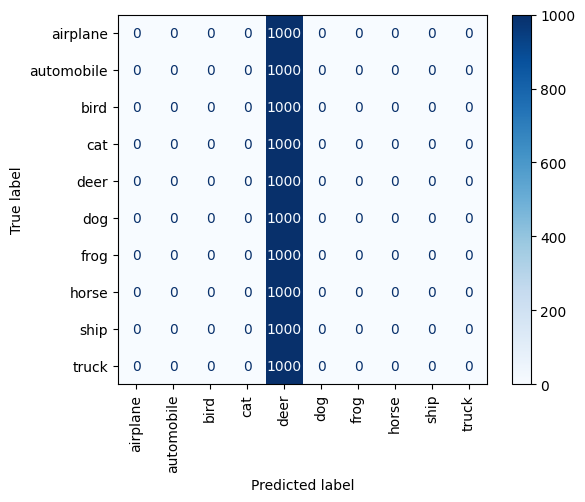

In [11]:
# Célula: 10-confmat
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = np.argmax(cnn_trained.predict(ds_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.savefig("figures/confusion_matrix_cnn.png", dpi=150)
print(classification_report(y_test, y_pred, target_names=classes))


In [12]:
# Célula: 11-gradcam (esqueleto)
import tensorflow.keras.backend as K
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Exibir overlay (usa matplotlib; transforma heatmap para tamanho da imagem).


In [13]:
# Célula: 13-errors
# encontra índices onde y_test != y_pred; agrupa por (true, pred) e conta


In [14]:
# app.py (esqueleto)
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf

st.title("CIFAR-10 demo")
uploaded = st.file_uploader("Upload image", type=['png','jpg'])
if uploaded:
    img = Image.open(uploaded).resize((32,32))
    st.image(img, caption="input", use_column_width=False)
    x = np.array(img).astype('float32')/255.0
    preds = cnn_trained.predict(x[np.newaxis,...])
    st.write({classes[i]: float(preds[0,i]) for i in range(10)})
    # gerar e exibir Grad-CAM


2025-09-27 18:13:42.028 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:13:42.267 
  command:

    streamlit run C:\Users\flori\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-27 18:13:42.268 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:13:42.269 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:13:42.270 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:13:42.270 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:13:42.270 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:13:42.271 Thre

In [12]:
import tensorflow as tf
import numpy as np

# Carregar MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizar
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Criar conjunto de validação
val_split = 0.1
num_val = int(len(x_train) * val_split)

x_val = x_train[:num_val]
y_val = y_train[:num_val]
x_train = x_train[num_val:]
y_train = y_train[num_val:]

# Adicionar canal se CNN esperar (28,28,1)
x_train_cnn = np.expand_dims(x_train, axis=-1)
x_val_cnn   = np.expand_dims(x_val, axis=-1)
x_test_cnn  = np.expand_dims(x_test, axis=-1)

# Criar datasets tf.data
batch_size = 32
ds_train = tf.data.Dataset.from_tensor_slices((x_train_cnn, y_train)).shuffle(1024).batch(batch_size)
ds_val   = tf.data.Dataset.from_tensor_slices((x_val_cnn, y_val)).batch(batch_size)
ds_test  = tf.data.Dataset.from_tensor_slices((x_test_cnn, y_test)).batch(batch_size)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
import os

# Cria a pasta "figures" se não existir
os.makedirs("figures", exist_ok=True)


In [15]:
import os
os.makedirs("figures", exist_ok=True)


In [ ]:
# ==========================================
# Experimentos com 3 seeds + Resultados
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models

# ==========================================
# Detectar número de classes e input_shape
# ==========================================
# Supondo que ds_train, ds_val, ds_test e y_test já estão definidos
# Detecta o formato das entradas automaticamente
sample_input, _ = next(iter(ds_train))
input_shape = sample_input.shape[1:]

# Detecta classes a partir de y_test
classes = np.unique(y_test)
num_classes = len(classes)

# ==========================================
# Definições dos modelos e treino
# ==========================================

# Modelo MLP
# Modelo MLP com Dropout + L2
def build_mlp(input_shape, num_classes, l2_reg=1e-4, dropout=0.5):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Modelo CNN
def build_mlp(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Função de treino
def train_model(model, ds_train, ds_val, seed, epochs=50, model_name="model"):
    tf.keras.utils.set_random_seed(seed)
    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=epochs,
        verbose=0
    )
    return history, model

# Função para plotar curvas
def plot_history(history, name):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='val')
    ax[0].set_title('Loss'); ax[0].legend()
    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].plot(history.history['val_accuracy'], label='val')
    ax[1].set_title('Accuracy'); ax[1].legend()
    plt.savefig(f"figures/{name}_curves.png", dpi=150)
    plt.close()

# ==========================================
# Experimentos
# ==========================================
seeds = [42, 123, 999]
results = []

for seed in seeds:
    # ---------------- MLP ----------------
    mlp = build_mlp(input_shape=input_shape, num_classes=num_classes)
    h_mlp, mlp_trained = train_model(mlp, ds_train, ds_val, seed=seed, epochs=50, model_name=f"mlp_{seed}")
    plot_history(h_mlp, f"mlp_seed{seed}")
    preds = np.argmax(mlp_trained.predict(ds_test), axis=1)
    acc = (preds == y_test).mean()
    f1 = f1_score(y_test, preds, average="macro")
    results.append({"model":"MLP","seed":seed,"acc":acc,"f1":f1})

    # ---------------- CNN ----------------
    cnn = build_cnn(input_shape=input_shape, num_classes=num_classes)
    h_cnn, cnn_trained = train_model(cnn, ds_train, ds_val, seed=seed, epochs=50, model_name=f"cnn_{seed}")
    plot_history(h_cnn, f"cnn_seed{seed}")
    preds = np.argmax(cnn_trained.predict(ds_test), axis=1)
    acc = (preds == y_test).mean()
    f1 = f1_score(y_test, preds, average="macro")
    results.append({"model":"CNN","seed":seed,"acc":acc,"f1":f1})

    # Matriz de confusão só da CNN (última seed)
    if seed == seeds[-1]:
        cm = confusion_matrix(y_test, preds)
        disp = ConfusionMatrixDisplay(cm, display_labels=classes)
        disp.plot(xticks_rotation="vertical", cmap="Blues")
        plt.savefig("figures/confusion_matrix_cnn.png", dpi=150)
        plt.close()

# Criar DataFrame e salvar tabela
df_results = pd.DataFrame(results)
df_results.to_csv("figures/results_table.csv", index=False)

print("\nResultados por execução:")
display(df_results)

print("\nMédia ± Desvio padrão por modelo:")
display(df_results.groupby("model").agg(["mean","std"]))



313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step


c:\Users\flori\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


c:\Users\flori\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step


c:\Users\flori\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Resultados por execução:


,model,seed,acc,f1
0,MLP,42,0.9810,0.980879
1,CNN,42,0.9904,0.990258
2,MLP,123,0.9774,0.977180
3,CNN,123,0.9910,0.990945
4,MLP,999,0.9806,0.980435
5,CNN,999,0.9915,0.991411



Média ± Desvio padrão por modelo:


seed                   acc                  f1         
        mean         std      mean       std      mean      std
model                                                          
CNN    388.0  530.689175  0.990967  0.000551  0.990871  0.00058
MLP    388.0  530.689175  0.979667  0.001973  0.979498  0.00202

In [18]:
# ==========================================
# Análise de erros (CNN última execução)
# ==========================================
import numpy as np  

# garantir compatibilidade (às vezes é x_test, às vezes X_test)
try:
    X_test
except NameError:
    X_test = x_test  

# Previsões da CNN final (última rodada do loop)
y_pred = np.argmax(cnn_trained.predict(ds_test), axis=1)

# Encontrar erros
errors_idx = np.where(y_pred != y_test)[0]
print(f"Total de erros: {len(errors_idx)}")

# Contar pares (verdadeiro -> predito)
from collections import Counter
pairs = [(y_test[i], y_pred[i]) for i in errors_idx]
most_common_pairs = Counter(pairs).most_common(3)
print("Pares de classes mais confundidas:", most_common_pairs)

# Função para plotar erros
def plot_errors(indices, name, max_imgs=15):
    n = min(len(indices), max_imgs)
    fig, axes = plt.subplots(1, n, figsize=(3*n,3))
    if n == 1:
        axes = [axes]
    for j, ax in enumerate(axes[:n]):
        idx = indices[j]
        ax.imshow(X_test[idx])
        ax.axis("off")
        ax.set_title(f"T:{classes[y_test[idx]]}\nP:{classes[y_pred[idx]]}", fontsize=9)
    plt.tight_layout()
    plt.savefig(f"figures/errors_{name}.png", dpi=150)
    plt.close()

# Plotar para os 3 pares mais confundidos
for (true_cls, pred_cls), _ in most_common_pairs:
    idxs = [i for i in errors_idx if y_test[i]==true_cls and y_pred[i]==pred_cls]
    plot_errors(idxs, f"{classes[true_cls]}_vs_{classes[pred_cls]}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Total de erros: 85
Pares de classes mais confundidas: [((np.uint8(9), np.int64(4)), 5), ((np.uint8(2), np.int64(7)), 5), ((np.uint8(5), np.int64(6)), 4)]


In [19]:
#Reprodutibilidade / seeds

import os, random, numpy as np, tensorflow as tf
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [20]:
#Carregamento e split CIFAR-10 + normalização + augmentation

from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# hold out validation set
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=5000, stratify=y_train, random_state=42)

# normalize
x_train = x_train.astype('float32')/255.0
x_val   = x_val.astype('float32')/255.0
x_test  = x_test.astype('float32')/255.0
y_train = y_train.ravel(); y_val = y_val.ravel(); y_test = y_test.ravel()

# data augmentation (use in CNN training)
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.05),
])


In [21]:
#Model builders (MLP e CNN) — parametrizados por dropout e L2

from tensorflow.keras import layers, models, regularizers

def build_mlp(input_shape=(32,32,3), num_classes=10, dropout_rate=0.0, l2=0.0):
    reg = regularizers.l2(l2) if l2>0 else None
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

def build_cnn(input_shape=(32,32,3), num_classes=10, dropout_rate=0.0, l2=0.0):
    reg = regularizers.l2(l2) if l2>0 else None
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    return model


In [22]:
#Verificação de parametros
m = build_cnn()
print("Params:", m.count_params())
assert m.count_params() <= 1_000_000, "Ajuste filtros para ter <= 1M params"


Params: 157226


In [23]:
#Função de treino reutilizável (salva history, melhor checkpoint)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def compile_and_train(model, x_train, y_train, x_val, y_val,
                      use_augment=False, epochs=50, batch_size=128,
                      model_name='model', save_dir='checkpoints', seed=42):
    set_seed(seed)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    os.makedirs(save_dir, exist_ok=True)
    ckpt_path = os.path.join(save_dir, f"{model_name}.h5")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
        ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss')
    ]
    if use_augment:
        train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size).map(
            lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    else:
        train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=2)
    return history, ckpt_path


In [25]:
#Rodar experimentos com diferentes seeds e agregar resultados
import os

os.makedirs("results", exist_ok=True)  # cria a pasta results se não existir
df.to_csv("results/summary.csv", index=False)


import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_model_checkpoint(ckpt_path, x_test, y_test, batch_size=128):
    model = tf.keras.models.load_model(ckpt_path)
    y_pred_probs = model.predict(x_test, batch_size=batch_size)
    y_pred = y_pred_probs.argmax(axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    return {'acc':acc, 'f1':f1, 'y_pred':y_pred, 'cm':cm, 'model':model}

results = []
seeds = [42, 43, 44]  # ideal: 3 seeds
for s in seeds:
    set_seed(s)
    model = build_cnn(dropout_rate=0.0, l2=0.0)
    history, ckpt = compile_and_train(model, x_train, y_train, x_val, y_val, use_augment=True,
                                      epochs=50, batch_size=128, model_name=f'cnn_seed{s}', seed=s)
    evald = evaluate_model_checkpoint(ckpt, x_test, y_test)
    results.append({'model':'cnn','seed':s,'acc':evald['acc'],'f1':evald['f1'],'ckpt':ckpt})
df = pd.DataFrame(results)
df.groupby('model')[['acc','f1']].agg(['mean','std'])
df.to_csv('results/summary.csv', index=False)


Epoch 1/50


352/352 - 23s - 66ms/step - accuracy: 0.2753 - loss: 1.8918 - val_accuracy: 0.4104 - val_loss: 1.5921 - learning_rate: 1.0000e-03
Epoch 2/50


352/352 - 21s - 59ms/step - accuracy: 0.4236 - loss: 1.5623 - val_accuracy: 0.4654 - val_loss: 1.4424 - learning_rate: 1.0000e-03
Epoch 3/50


352/352 - 21s - 59ms/step - accuracy: 0.4858 - loss: 1.4100 - val_accuracy: 0.4928 - val_loss: 1.4308 - learning_rate: 1.0000e-03
Epoch 4/50


352/352 - 21s - 59ms/step - accuracy: 0.5202 - loss: 1.3266 - val_accuracy: 0.5352 - val_loss: 1.2833 - learning_rate: 1.0000e-03
Epoch 5/50
352/352 - 21s - 59ms/step - accuracy: 0.5567 - loss: 1.2282 - val_accuracy: 0.5558 - val_loss: 1.2949 - learning_rate: 1.0000e-03
Epoch 6/50


352/352 - 21s - 59ms/step - accuracy: 0.5739 - loss: 1.1834 - val_accuracy: 0.5500 - val_loss: 1.2706 - learning_rate: 1.0000e-03
Epoch 7/50


352/352 - 23s - 65ms/step - accuracy: 0.6031 - loss: 1.1114 - val_accuracy: 0.6144 - val_loss: 1.1033 - learning_rate: 1.0000e-03
Epoch 8/50


352/352 - 22s - 63ms/step - accuracy: 0.6184 - loss: 1.0749 - val_accuracy: 0.6294 - val_loss: 1.0857 - learning_rate: 1.0000e-03
Epoch 9/50


352/352 - 21s - 59ms/step - accuracy: 0.6323 - loss: 1.0399 - val_accuracy: 0.6390 - val_loss: 1.0432 - learning_rate: 1.0000e-03
Epoch 10/50


352/352 - 21s - 59ms/step - accuracy: 0.6446 - loss: 0.9998 - val_accuracy: 0.6506 - val_loss: 1.0101 - learning_rate: 1.0000e-03
Epoch 11/50
352/352 - 21s - 59ms/step - accuracy: 0.6568 - loss: 0.9703 - val_accuracy: 0.6276 - val_loss: 1.1353 - learning_rate: 1.0000e-03
Epoch 12/50


352/352 - 21s - 60ms/step - accuracy: 0.6664 - loss: 0.9440 - val_accuracy: 0.6672 - val_loss: 0.9470 - learning_rate: 1.0000e-03
Epoch 13/50
352/352 - 21s - 59ms/step - accuracy: 0.6796 - loss: 0.9105 - val_accuracy: 0.6674 - val_loss: 0.9510 - learning_rate: 1.0000e-03
Epoch 14/50


352/352 - 21s - 59ms/step - accuracy: 0.6867 - loss: 0.8865 - val_accuracy: 0.6938 - val_loss: 0.8856 - learning_rate: 1.0000e-03
Epoch 15/50


352/352 - 21s - 60ms/step - accuracy: 0.6927 - loss: 0.8685 - val_accuracy: 0.7052 - val_loss: 0.8752 - learning_rate: 1.0000e-03
Epoch 16/50


352/352 - 22s - 62ms/step - accuracy: 0.7026 - loss: 0.8438 - val_accuracy: 0.7154 - val_loss: 0.8221 - learning_rate: 1.0000e-03
Epoch 17/50
352/352 - 21s - 61ms/step - accuracy: 0.7137 - loss: 0.8163 - val_accuracy: 0.7056 - val_loss: 0.8748 - learning_rate: 1.0000e-03
Epoch 18/50


352/352 - 21s - 61ms/step - accuracy: 0.7162 - loss: 0.8082 - val_accuracy: 0.7224 - val_loss: 0.8041 - learning_rate: 1.0000e-03
Epoch 19/50
352/352 - 21s - 59ms/step - accuracy: 0.7223 - loss: 0.7884 - val_accuracy: 0.6922 - val_loss: 0.9078 - learning_rate: 1.0000e-03
Epoch 20/50
352/352 - 21s - 60ms/step - accuracy: 0.7296 - loss: 0.7663 - val_accuracy: 0.7126 - val_loss: 0.8569 - learning_rate: 1.0000e-03
Epoch 21/50
352/352 - 22s - 61ms/step - accuracy: 0.7367 - loss: 0.7447 - val_accuracy: 0.7050 - val_loss: 0.8921 - learning_rate: 1.0000e-03
Epoch 22/50


352/352 - 21s - 60ms/step - accuracy: 0.7552 - loss: 0.6968 - val_accuracy: 0.7384 - val_loss: 0.7730 - learning_rate: 5.0000e-04
Epoch 23/50


352/352 - 22s - 63ms/step - accuracy: 0.7646 - loss: 0.6730 - val_accuracy: 0.7694 - val_loss: 0.6755 - learning_rate: 5.0000e-04
Epoch 24/50
352/352 - 22s - 62ms/step - accuracy: 0.7673 - loss: 0.6634 - val_accuracy: 0.7420 - val_loss: 0.7589 - learning_rate: 5.0000e-04
Epoch 25/50
352/352 - 22s - 61ms/step - accuracy: 0.7678 - loss: 0.6633 - val_accuracy: 0.7592 - val_loss: 0.7003 - learning_rate: 5.0000e-04
Epoch 26/50
352/352 - 21s - 60ms/step - accuracy: 0.7699 - loss: 0.6564 - val_accuracy: 0.7618 - val_loss: 0.6826 - learning_rate: 5.0000e-04
Epoch 27/50
352/352 - 21s - 60ms/step - accuracy: 0.7842 - loss: 0.6115 - val_accuracy: 0.7632 - val_loss: 0.6911 - learning_rate: 2.5000e-04
Epoch 28/50


352/352 - 21s - 60ms/step - accuracy: 0.7833 - loss: 0.6125 - val_accuracy: 0.7802 - val_loss: 0.6362 - learning_rate: 2.5000e-04
Epoch 29/50
352/352 - 21s - 60ms/step - accuracy: 0.7858 - loss: 0.6096 - val_accuracy: 0.7660 - val_loss: 0.6750 - learning_rate: 2.5000e-04
Epoch 30/50
352/352 - 21s - 60ms/step - accuracy: 0.7894 - loss: 0.6021 - val_accuracy: 0.7698 - val_loss: 0.6727 - learning_rate: 2.5000e-04
Epoch 31/50
352/352 - 22s - 62ms/step - accuracy: 0.7895 - loss: 0.6013 - val_accuracy: 0.7732 - val_loss: 0.6533 - learning_rate: 2.5000e-04
Epoch 32/50
352/352 - 21s - 59ms/step - accuracy: 0.7995 - loss: 0.5759 - val_accuracy: 0.7758 - val_loss: 0.6555 - learning_rate: 1.2500e-04
Epoch 33/50
352/352 - 21s - 59ms/step - accuracy: 0.7999 - loss: 0.5767 - val_accuracy: 0.7760 - val_loss: 0.6483 - learning_rate: 1.2500e-04
Epoch 34/50
352/352 - 21s - 61ms/step - accuracy: 0.7979 - loss: 0.5754 - val_accuracy: 0.7802 - val_loss: 0.6395 - learning_rate: 1.2500e-04


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Epoch 1/50


352/352 - 25s - 71ms/step - accuracy: 0.2834 - loss: 1.8940 - val_accuracy: 0.3724 - val_loss: 1.6785 - learning_rate: 1.0000e-03
Epoch 2/50


352/352 - 24s - 68ms/step - accuracy: 0.4156 - loss: 1.5841 - val_accuracy: 0.4308 - val_loss: 1.5092 - learning_rate: 1.0000e-03
Epoch 3/50


352/352 - 23s - 66ms/step - accuracy: 0.4808 - loss: 1.4093 - val_accuracy: 0.5208 - val_loss: 1.3105 - learning_rate: 1.0000e-03
Epoch 4/50


352/352 - 24s - 67ms/step - accuracy: 0.5250 - loss: 1.3050 - val_accuracy: 0.5412 - val_loss: 1.2465 - learning_rate: 1.0000e-03
Epoch 5/50


352/352 - 23s - 66ms/step - accuracy: 0.5528 - loss: 1.2356 - val_accuracy: 0.5722 - val_loss: 1.1791 - learning_rate: 1.0000e-03
Epoch 6/50
352/352 - 22s - 62ms/step - accuracy: 0.5730 - loss: 1.1799 - val_accuracy: 0.5820 - val_loss: 1.1798 - learning_rate: 1.0000e-03
Epoch 7/50


352/352 - 24s - 68ms/step - accuracy: 0.5924 - loss: 1.1301 - val_accuracy: 0.6192 - val_loss: 1.0685 - learning_rate: 1.0000e-03
Epoch 8/50
352/352 - 23s - 65ms/step - accuracy: 0.6123 - loss: 1.0782 - val_accuracy: 0.6144 - val_loss: 1.0704 - learning_rate: 1.0000e-03
Epoch 9/50


352/352 - 23s - 64ms/step - accuracy: 0.6267 - loss: 1.0410 - val_accuracy: 0.6338 - val_loss: 1.0523 - learning_rate: 1.0000e-03
Epoch 10/50


352/352 - 22s - 61ms/step - accuracy: 0.6392 - loss: 1.0070 - val_accuracy: 0.6408 - val_loss: 1.0189 - learning_rate: 1.0000e-03
Epoch 11/50


352/352 - 27s - 76ms/step - accuracy: 0.6530 - loss: 0.9710 - val_accuracy: 0.6676 - val_loss: 0.9538 - learning_rate: 1.0000e-03
Epoch 12/50
352/352 - 23s - 65ms/step - accuracy: 0.6621 - loss: 0.9491 - val_accuracy: 0.6590 - val_loss: 0.9868 - learning_rate: 1.0000e-03
Epoch 13/50
352/352 - 22s - 61ms/step - accuracy: 0.6713 - loss: 0.9259 - val_accuracy: 0.6678 - val_loss: 0.9577 - learning_rate: 1.0000e-03
Epoch 14/50
352/352 - 23s - 64ms/step - accuracy: 0.6805 - loss: 0.8973 - val_accuracy: 0.6586 - val_loss: 0.9699 - learning_rate: 1.0000e-03
Epoch 15/50


352/352 - 24s - 68ms/step - accuracy: 0.7045 - loss: 0.8345 - val_accuracy: 0.6984 - val_loss: 0.8894 - learning_rate: 5.0000e-04
Epoch 16/50
352/352 - 23s - 65ms/step - accuracy: 0.7109 - loss: 0.8190 - val_accuracy: 0.6868 - val_loss: 0.9250 - learning_rate: 5.0000e-04
Epoch 17/50


352/352 - 24s - 68ms/step - accuracy: 0.7170 - loss: 0.8032 - val_accuracy: 0.7000 - val_loss: 0.8868 - learning_rate: 5.0000e-04
Epoch 18/50


352/352 - 23s - 66ms/step - accuracy: 0.7214 - loss: 0.7903 - val_accuracy: 0.7074 - val_loss: 0.8686 - learning_rate: 5.0000e-04
Epoch 19/50


352/352 - 23s - 67ms/step - accuracy: 0.7254 - loss: 0.7775 - val_accuracy: 0.7308 - val_loss: 0.7778 - learning_rate: 5.0000e-04
Epoch 20/50
352/352 - 21s - 61ms/step - accuracy: 0.7286 - loss: 0.7673 - val_accuracy: 0.6978 - val_loss: 0.8927 - learning_rate: 5.0000e-04
Epoch 21/50


352/352 - 21s - 60ms/step - accuracy: 0.7325 - loss: 0.7559 - val_accuracy: 0.7382 - val_loss: 0.7649 - learning_rate: 5.0000e-04
Epoch 22/50


352/352 - 22s - 62ms/step - accuracy: 0.7375 - loss: 0.7456 - val_accuracy: 0.7454 - val_loss: 0.7542 - learning_rate: 5.0000e-04
Epoch 23/50
352/352 - 21s - 60ms/step - accuracy: 0.7408 - loss: 0.7322 - val_accuracy: 0.7310 - val_loss: 0.8083 - learning_rate: 5.0000e-04
Epoch 24/50
352/352 - 21s - 60ms/step - accuracy: 0.7444 - loss: 0.7251 - val_accuracy: 0.7444 - val_loss: 0.7550 - learning_rate: 5.0000e-04
Epoch 25/50
352/352 - 21s - 61ms/step - accuracy: 0.7486 - loss: 0.7134 - val_accuracy: 0.7346 - val_loss: 0.7854 - learning_rate: 5.0000e-04
Epoch 26/50


352/352 - 21s - 60ms/step - accuracy: 0.7620 - loss: 0.6757 - val_accuracy: 0.7418 - val_loss: 0.7505 - learning_rate: 2.5000e-04
Epoch 27/50


352/352 - 23s - 64ms/step - accuracy: 0.7653 - loss: 0.6702 - val_accuracy: 0.7542 - val_loss: 0.7244 - learning_rate: 2.5000e-04
Epoch 28/50


352/352 - 23s - 65ms/step - accuracy: 0.7656 - loss: 0.6682 - val_accuracy: 0.7576 - val_loss: 0.7143 - learning_rate: 2.5000e-04
Epoch 29/50
352/352 - 23s - 66ms/step - accuracy: 0.7676 - loss: 0.6608 - val_accuracy: 0.7518 - val_loss: 0.7363 - learning_rate: 2.5000e-04
Epoch 30/50
352/352 - 22s - 63ms/step - accuracy: 0.7702 - loss: 0.6545 - val_accuracy: 0.7512 - val_loss: 0.7247 - learning_rate: 2.5000e-04
Epoch 31/50
352/352 - 22s - 63ms/step - accuracy: 0.7703 - loss: 0.6508 - val_accuracy: 0.7488 - val_loss: 0.7390 - learning_rate: 2.5000e-04
Epoch 32/50


352/352 - 22s - 62ms/step - accuracy: 0.7779 - loss: 0.6277 - val_accuracy: 0.7582 - val_loss: 0.6991 - learning_rate: 1.2500e-04
Epoch 33/50


352/352 - 22s - 61ms/step - accuracy: 0.7807 - loss: 0.6286 - val_accuracy: 0.7628 - val_loss: 0.6967 - learning_rate: 1.2500e-04
Epoch 34/50
352/352 - 21s - 60ms/step - accuracy: 0.7824 - loss: 0.6236 - val_accuracy: 0.7450 - val_loss: 0.7517 - learning_rate: 1.2500e-04
Epoch 35/50
352/352 - 23s - 65ms/step - accuracy: 0.7816 - loss: 0.6214 - val_accuracy: 0.7554 - val_loss: 0.7197 - learning_rate: 1.2500e-04
Epoch 36/50
352/352 - 22s - 63ms/step - accuracy: 0.7836 - loss: 0.6166 - val_accuracy: 0.7598 - val_loss: 0.7280 - learning_rate: 1.2500e-04
Epoch 37/50
352/352 - 22s - 63ms/step - accuracy: 0.7862 - loss: 0.6094 - val_accuracy: 0.7648 - val_loss: 0.7017 - learning_rate: 6.2500e-05
Epoch 38/50


352/352 - 23s - 65ms/step - accuracy: 0.7879 - loss: 0.6051 - val_accuracy: 0.7674 - val_loss: 0.6865 - learning_rate: 6.2500e-05
Epoch 39/50
352/352 - 22s - 63ms/step - accuracy: 0.7881 - loss: 0.6009 - val_accuracy: 0.7654 - val_loss: 0.7041 - learning_rate: 6.2500e-05
Epoch 40/50
352/352 - 21s - 60ms/step - accuracy: 0.7874 - loss: 0.6076 - val_accuracy: 0.7660 - val_loss: 0.6884 - learning_rate: 6.2500e-05
Epoch 41/50


352/352 - 21s - 60ms/step - accuracy: 0.7862 - loss: 0.6026 - val_accuracy: 0.7678 - val_loss: 0.6857 - learning_rate: 6.2500e-05
Epoch 42/50


352/352 - 21s - 59ms/step - accuracy: 0.7860 - loss: 0.6035 - val_accuracy: 0.7734 - val_loss: 0.6770 - learning_rate: 6.2500e-05
Epoch 43/50
352/352 - 21s - 61ms/step - accuracy: 0.7883 - loss: 0.6001 - val_accuracy: 0.7690 - val_loss: 0.6925 - learning_rate: 6.2500e-05
Epoch 44/50
352/352 - 21s - 60ms/step - accuracy: 0.7910 - loss: 0.5989 - val_accuracy: 0.7594 - val_loss: 0.7150 - learning_rate: 6.2500e-05
Epoch 45/50
352/352 - 21s - 60ms/step - accuracy: 0.7921 - loss: 0.5955 - val_accuracy: 0.7606 - val_loss: 0.7012 - learning_rate: 6.2500e-05
Epoch 46/50
352/352 - 21s - 59ms/step - accuracy: 0.7927 - loss: 0.5901 - val_accuracy: 0.7682 - val_loss: 0.6858 - learning_rate: 3.1250e-05
Epoch 47/50
352/352 - 22s - 61ms/step - accuracy: 0.7929 - loss: 0.5880 - val_accuracy: 0.7666 - val_loss: 0.6892 - learning_rate: 3.1250e-05
Epoch 48/50
352/352 - 22s - 63ms/step - accuracy: 0.7940 - loss: 0.5875 - val_accuracy: 0.7670 - val_loss: 0.6870 - learning_rate: 3.1250e-05


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Epoch 1/50


352/352 - 23s - 66ms/step - accuracy: 0.2755 - loss: 1.9135 - val_accuracy: 0.3932 - val_loss: 1.6043 - learning_rate: 1.0000e-03
Epoch 2/50


352/352 - 25s - 71ms/step - accuracy: 0.4126 - loss: 1.5771 - val_accuracy: 0.4486 - val_loss: 1.4711 - learning_rate: 1.0000e-03
Epoch 3/50


352/352 - 22s - 64ms/step - accuracy: 0.4768 - loss: 1.4305 - val_accuracy: 0.5004 - val_loss: 1.3642 - learning_rate: 1.0000e-03
Epoch 4/50


352/352 - 22s - 62ms/step - accuracy: 0.5211 - loss: 1.3153 - val_accuracy: 0.5540 - val_loss: 1.2139 - learning_rate: 1.0000e-03
Epoch 5/50
352/352 - 22s - 63ms/step - accuracy: 0.5590 - loss: 1.2216 - val_accuracy: 0.5670 - val_loss: 1.2258 - learning_rate: 1.0000e-03
Epoch 6/50


352/352 - 22s - 61ms/step - accuracy: 0.5875 - loss: 1.1523 - val_accuracy: 0.6034 - val_loss: 1.1032 - learning_rate: 1.0000e-03
Epoch 7/50
352/352 - 22s - 63ms/step - accuracy: 0.6067 - loss: 1.1040 - val_accuracy: 0.6030 - val_loss: 1.1576 - learning_rate: 1.0000e-03
Epoch 8/50
352/352 - 22s - 63ms/step - accuracy: 0.6226 - loss: 1.0638 - val_accuracy: 0.6024 - val_loss: 1.1743 - learning_rate: 1.0000e-03
Epoch 9/50


352/352 - 22s - 61ms/step - accuracy: 0.6362 - loss: 1.0234 - val_accuracy: 0.6342 - val_loss: 1.0309 - learning_rate: 1.0000e-03
Epoch 10/50
352/352 - 22s - 61ms/step - accuracy: 0.6476 - loss: 0.9893 - val_accuracy: 0.6392 - val_loss: 1.0397 - learning_rate: 1.0000e-03
Epoch 11/50


352/352 - 24s - 69ms/step - accuracy: 0.6558 - loss: 0.9703 - val_accuracy: 0.6622 - val_loss: 0.9498 - learning_rate: 1.0000e-03
Epoch 12/50


352/352 - 23s - 65ms/step - accuracy: 0.6673 - loss: 0.9391 - val_accuracy: 0.6748 - val_loss: 0.9256 - learning_rate: 1.0000e-03
Epoch 13/50


352/352 - 23s - 66ms/step - accuracy: 0.6777 - loss: 0.9172 - val_accuracy: 0.6832 - val_loss: 0.9025 - learning_rate: 1.0000e-03
Epoch 14/50
352/352 - 23s - 66ms/step - accuracy: 0.6838 - loss: 0.8962 - val_accuracy: 0.6554 - val_loss: 1.0061 - learning_rate: 1.0000e-03
Epoch 15/50


352/352 - 23s - 65ms/step - accuracy: 0.6940 - loss: 0.8658 - val_accuracy: 0.6948 - val_loss: 0.8832 - learning_rate: 1.0000e-03
Epoch 16/50


352/352 - 22s - 63ms/step - accuracy: 0.7033 - loss: 0.8518 - val_accuracy: 0.7002 - val_loss: 0.8622 - learning_rate: 1.0000e-03
Epoch 17/50
352/352 - 23s - 65ms/step - accuracy: 0.7106 - loss: 0.8246 - val_accuracy: 0.6666 - val_loss: 1.0065 - learning_rate: 1.0000e-03
Epoch 18/50


352/352 - 23s - 65ms/step - accuracy: 0.7138 - loss: 0.8128 - val_accuracy: 0.7050 - val_loss: 0.8343 - learning_rate: 1.0000e-03
Epoch 19/50
352/352 - 23s - 66ms/step - accuracy: 0.7206 - loss: 0.7961 - val_accuracy: 0.7138 - val_loss: 0.8427 - learning_rate: 1.0000e-03
Epoch 20/50


352/352 - 22s - 64ms/step - accuracy: 0.7290 - loss: 0.7711 - val_accuracy: 0.7384 - val_loss: 0.7530 - learning_rate: 1.0000e-03
Epoch 21/50
352/352 - 24s - 67ms/step - accuracy: 0.7320 - loss: 0.7643 - val_accuracy: 0.7348 - val_loss: 0.7841 - learning_rate: 1.0000e-03
Epoch 22/50
352/352 - 23s - 66ms/step - accuracy: 0.7408 - loss: 0.7427 - val_accuracy: 0.7112 - val_loss: 0.8802 - learning_rate: 1.0000e-03
Epoch 23/50
352/352 - 24s - 70ms/step - accuracy: 0.7455 - loss: 0.7269 - val_accuracy: 0.7394 - val_loss: 0.7809 - learning_rate: 1.0000e-03
Epoch 24/50


352/352 - 23s - 66ms/step - accuracy: 0.7633 - loss: 0.6759 - val_accuracy: 0.7504 - val_loss: 0.7376 - learning_rate: 5.0000e-04
Epoch 25/50


352/352 - 24s - 68ms/step - accuracy: 0.7674 - loss: 0.6658 - val_accuracy: 0.7538 - val_loss: 0.7149 - learning_rate: 5.0000e-04
Epoch 26/50
352/352 - 23s - 65ms/step - accuracy: 0.7707 - loss: 0.6528 - val_accuracy: 0.7392 - val_loss: 0.7832 - learning_rate: 5.0000e-04
Epoch 27/50


352/352 - 24s - 68ms/step - accuracy: 0.7747 - loss: 0.6443 - val_accuracy: 0.7564 - val_loss: 0.6970 - learning_rate: 5.0000e-04
Epoch 28/50
352/352 - 24s - 68ms/step - accuracy: 0.7778 - loss: 0.6332 - val_accuracy: 0.7424 - val_loss: 0.7597 - learning_rate: 5.0000e-04
Epoch 29/50
352/352 - 23s - 65ms/step - accuracy: 0.7775 - loss: 0.6291 - val_accuracy: 0.7432 - val_loss: 0.7641 - learning_rate: 5.0000e-04
Epoch 30/50


352/352 - 25s - 72ms/step - accuracy: 0.7808 - loss: 0.6221 - val_accuracy: 0.7674 - val_loss: 0.6791 - learning_rate: 5.0000e-04
Epoch 31/50
352/352 - 25s - 70ms/step - accuracy: 0.7863 - loss: 0.6090 - val_accuracy: 0.7652 - val_loss: 0.6880 - learning_rate: 5.0000e-04
Epoch 32/50


352/352 - 22s - 61ms/step - accuracy: 0.7894 - loss: 0.6018 - val_accuracy: 0.7698 - val_loss: 0.6753 - learning_rate: 5.0000e-04
Epoch 33/50
352/352 - 21s - 60ms/step - accuracy: 0.7886 - loss: 0.6032 - val_accuracy: 0.7688 - val_loss: 0.6973 - learning_rate: 5.0000e-04
Epoch 34/50


352/352 - 24s - 69ms/step - accuracy: 0.7912 - loss: 0.5984 - val_accuracy: 0.7828 - val_loss: 0.6354 - learning_rate: 5.0000e-04
Epoch 35/50
352/352 - 24s - 67ms/step - accuracy: 0.7944 - loss: 0.5870 - val_accuracy: 0.7704 - val_loss: 0.6933 - learning_rate: 5.0000e-04
Epoch 36/50
352/352 - 24s - 68ms/step - accuracy: 0.7953 - loss: 0.5824 - val_accuracy: 0.7716 - val_loss: 0.6774 - learning_rate: 5.0000e-04
Epoch 37/50
352/352 - 23s - 65ms/step - accuracy: 0.7974 - loss: 0.5773 - val_accuracy: 0.7658 - val_loss: 0.7231 - learning_rate: 5.0000e-04
Epoch 38/50
352/352 - 23s - 66ms/step - accuracy: 0.8093 - loss: 0.5430 - val_accuracy: 0.7702 - val_loss: 0.6835 - learning_rate: 2.5000e-04
Epoch 39/50


352/352 - 24s - 69ms/step - accuracy: 0.8114 - loss: 0.5401 - val_accuracy: 0.7876 - val_loss: 0.6314 - learning_rate: 2.5000e-04
Epoch 40/50


352/352 - 25s - 72ms/step - accuracy: 0.8112 - loss: 0.5376 - val_accuracy: 0.7944 - val_loss: 0.6217 - learning_rate: 2.5000e-04
Epoch 41/50
352/352 - 23s - 65ms/step - accuracy: 0.8115 - loss: 0.5378 - val_accuracy: 0.7794 - val_loss: 0.6555 - learning_rate: 2.5000e-04
Epoch 42/50
352/352 - 22s - 64ms/step - accuracy: 0.8164 - loss: 0.5280 - val_accuracy: 0.7790 - val_loss: 0.6687 - learning_rate: 2.5000e-04
Epoch 43/50


352/352 - 23s - 66ms/step - accuracy: 0.8147 - loss: 0.5289 - val_accuracy: 0.7930 - val_loss: 0.6145 - learning_rate: 2.5000e-04
Epoch 44/50
352/352 - 22s - 63ms/step - accuracy: 0.8167 - loss: 0.5237 - val_accuracy: 0.7866 - val_loss: 0.6355 - learning_rate: 2.5000e-04
Epoch 45/50
352/352 - 22s - 62ms/step - accuracy: 0.8171 - loss: 0.5238 - val_accuracy: 0.7906 - val_loss: 0.6198 - learning_rate: 2.5000e-04
Epoch 46/50
352/352 - 21s - 61ms/step - accuracy: 0.8202 - loss: 0.5174 - val_accuracy: 0.7872 - val_loss: 0.6265 - learning_rate: 2.5000e-04
Epoch 47/50
352/352 - 22s - 62ms/step - accuracy: 0.8249 - loss: 0.5021 - val_accuracy: 0.7924 - val_loss: 0.6213 - learning_rate: 1.2500e-04
Epoch 48/50
352/352 - 22s - 62ms/step - accuracy: 0.8270 - loss: 0.4988 - val_accuracy: 0.7816 - val_loss: 0.6566 - learning_rate: 1.2500e-04
Epoch 49/50
352/352 - 22s - 62ms/step - accuracy: 0.8263 - loss: 0.4924 - val_accuracy: 0.7910 - val_loss: 0.6380 - learning_rate: 1.2500e-04


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [26]:
#Plots: curvas treino/val, exemplos do dataset, matriz de confusão

import matplotlib.pyplot as plt
def plot_history(history, fname='figures/curvas.png'):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend(); plt.title('Accuracy')
    plt.tight_layout()
    plt.savefig(fname, dpi=150)

def plot_examples(x, y, class_names, fname='figures/examples.png'):
    plt.figure(figsize=(8,4))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(x[i])
        plt.title(class_names[y[i]])
        plt.axis('off')
    plt.tight_layout(); plt.savefig(fname, dpi=150)

def plot_confusion(cm, class_names, fname='figures/confusion.png'):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest')
    plt.colorbar()
    ticks = range(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.savefig(fname, dpi=150)


In [27]:
#Grad-CAM (Keras) — função para gerar heatmap e sobrepor

import numpy as np
import tensorflow as tf
from PIL import Image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap_on_image(img, heatmap, alpha=0.4):
    # img: uint8 [H,W,3] or float [0,1]
    import matplotlib.cm as cm
    heatmap_resized = np.uint8(255 * plt.cm.jet(heatmap)[:,:,:3])  # RGB heatmap
    heatmap_resized = Image.fromarray(heatmap_resized).resize((img.shape[1], img.shape[0]))
    heatmap_resized = np.array(heatmap_resized).astype(float)/255.0
    overlay = (1-alpha)*img + alpha*heatmap_resized
    overlay = np.uint8(255 * overlay / overlay.max())
    return overlay


In [30]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# garante que a pasta checkpoints existe
os.makedirs("checkpoints", exist_ok=True)

def train_and_save_best_cnn(x_train, y_train, x_val, y_val, epochs=30, batch_size=128):
    model = build_cnn()  # sua função de modelo já definida antes
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
        ModelCheckpoint("checkpoints/best_cnn.h5", save_best_only=True, monitor="val_loss")
    ]

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=2
    )

    # no final, também salva a versão final por garantia
    model.save("checkpoints/best_cnn.h5")
    return model, history

# exemplo de treino
model, history = train_and_save_best_cnn(x_train, y_train, x_val, y_val, epochs=20)


Epoch 1/20


352/352 - 22s - 62ms/step - accuracy: 0.3126 - loss: 1.8117 - val_accuracy: 0.3914 - val_loss: 1.5579 - learning_rate: 1.0000e-03
Epoch 2/20


352/352 - 21s - 61ms/step - accuracy: 0.4598 - loss: 1.4566 - val_accuracy: 0.5028 - val_loss: 1.3170 - learning_rate: 1.0000e-03
Epoch 3/20


352/352 - 20s - 57ms/step - accuracy: 0.5382 - loss: 1.2569 - val_accuracy: 0.5566 - val_loss: 1.2052 - learning_rate: 1.0000e-03
Epoch 4/20


352/352 - 20s - 58ms/step - accuracy: 0.5930 - loss: 1.1263 - val_accuracy: 0.6098 - val_loss: 1.0773 - learning_rate: 1.0000e-03
Epoch 5/20


352/352 - 20s - 58ms/step - accuracy: 0.6288 - loss: 1.0397 - val_accuracy: 0.6432 - val_loss: 0.9987 - learning_rate: 1.0000e-03
Epoch 6/20


352/352 - 21s - 61ms/step - accuracy: 0.6520 - loss: 0.9781 - val_accuracy: 0.6634 - val_loss: 0.9386 - learning_rate: 1.0000e-03
Epoch 7/20


352/352 - 20s - 57ms/step - accuracy: 0.6727 - loss: 0.9193 - val_accuracy: 0.6788 - val_loss: 0.8906 - learning_rate: 1.0000e-03
Epoch 8/20


352/352 - 22s - 62ms/step - accuracy: 0.6923 - loss: 0.8678 - val_accuracy: 0.6984 - val_loss: 0.8515 - learning_rate: 1.0000e-03
Epoch 9/20


352/352 - 22s - 63ms/step - accuracy: 0.7086 - loss: 0.8235 - val_accuracy: 0.7114 - val_loss: 0.8237 - learning_rate: 1.0000e-03
Epoch 10/20


352/352 - 22s - 61ms/step - accuracy: 0.7242 - loss: 0.7847 - val_accuracy: 0.7234 - val_loss: 0.7987 - learning_rate: 1.0000e-03
Epoch 11/20


352/352 - 21s - 60ms/step - accuracy: 0.7377 - loss: 0.7467 - val_accuracy: 0.7346 - val_loss: 0.7779 - learning_rate: 1.0000e-03
Epoch 12/20


352/352 - 20s - 58ms/step - accuracy: 0.7489 - loss: 0.7150 - val_accuracy: 0.7376 - val_loss: 0.7560 - learning_rate: 1.0000e-03
Epoch 13/20


352/352 - 20s - 57ms/step - accuracy: 0.7606 - loss: 0.6835 - val_accuracy: 0.7436 - val_loss: 0.7342 - learning_rate: 1.0000e-03
Epoch 14/20


352/352 - 21s - 60ms/step - accuracy: 0.7701 - loss: 0.6532 - val_accuracy: 0.7470 - val_loss: 0.7201 - learning_rate: 1.0000e-03
Epoch 15/20


352/352 - 24s - 67ms/step - accuracy: 0.7802 - loss: 0.6243 - val_accuracy: 0.7512 - val_loss: 0.7062 - learning_rate: 1.0000e-03
Epoch 16/20


352/352 - 20s - 56ms/step - accuracy: 0.7916 - loss: 0.5959 - val_accuracy: 0.7604 - val_loss: 0.6898 - learning_rate: 1.0000e-03
Epoch 17/20
352/352 - 20s - 56ms/step - accuracy: 0.8015 - loss: 0.5684 - val_accuracy: 0.7622 - val_loss: 0.6989 - learning_rate: 1.0000e-03
Epoch 18/20
352/352 - 20s - 56ms/step - accuracy: 0.8116 - loss: 0.5427 - val_accuracy: 0.7648 - val_loss: 0.7000 - learning_rate: 1.0000e-03
Epoch 19/20


352/352 - 20s - 56ms/step - accuracy: 0.8180 - loss: 0.5244 - val_accuracy: 0.7648 - val_loss: 0.6882 - learning_rate: 1.0000e-03
Epoch 20/20


352/352 - 21s - 59ms/step - accuracy: 0.8259 - loss: 0.5024 - val_accuracy: 0.7760 - val_loss: 0.6738 - learning_rate: 1.0000e-03


In [31]:
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# === Classes CIFAR-10 ===
CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# === Funções Grad-CAM ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap_on_image(img, heatmap, alpha=0.4):
    import matplotlib.cm as cm
    heatmap_resized = np.uint8(255 * cm.jet(heatmap)[:,:,:3])  
    heatmap_resized = Image.fromarray(heatmap_resized).resize((img.shape[1], img.shape[0]))
    heatmap_resized = np.array(heatmap_resized).astype(float)/255.0
    overlay = (1-alpha)*img + alpha*heatmap_resized
    overlay = np.uint8(255 * overlay / overlay.max())
    return overlay

# === Carregar modelo salvo ===
@st.cache_resource
def load_model(path='checkpoints/best_cnn.h5'):
    return tf.keras.models.load_model(path)

model = load_model()

# === Interface ===
st.title("Demo: CIFAR-10 — CNN + Grad-CAM")
uploaded = st.file_uploader("Envie uma imagem (RGB)", type=['png','jpg','jpeg'])

if uploaded:
    img = Image.open(uploaded).convert('RGB').resize((32,32))
    st.image(img, caption='Input', use_column_width=False)

    x = np.array(img).astype('float32')/255.0
    preds = model.predict(x[None,...])[0]

    # mostrar probabilidades
    for i,p in enumerate(preds):
        st.write(f"{CLASS_NAMES[i]}: {p:.3f}")
    pred_idx = np.argmax(preds)
    st.write("Predicted:", CLASS_NAMES[pred_idx])

    # Grad-CAM
    last_conv = None
    for layer in reversed(model.layers):
        if 'conv' in layer.name and 'Conv' in str(type(layer)):
            last_conv = layer.name
            break
    heatmap = make_gradcam_heatmap(x[None,...], model, last_conv, pred_index=pred_idx)
    overlay = overlay_heatmap_on_image(np.array(img)/255.0, heatmap)
    st.image(overlay, caption='Grad-CAM overlay', use_column_width=False)


2025-09-27 21:04:23.566 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 21:04:23.567 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 21:04:23.568 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 21:04:23.568 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 21:04:23.658 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 21:04:23.659 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 21:04:23.659 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 21:04:23.660 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [32]:
import os
os.makedirs("checkpoints", exist_ok=True)
model.save("checkpoints/best_cnn.h5")